In [1]:
import tensorflow
import numpy as np

In [2]:
x = np.array([2, -1, 3, -2, 2, 2, 1, -4, 5, 1])
w = np.array([-1, -1, 1, -1, 1, -1, 1, 1, -1, 1])

## Toy Example showing the phenomenal of fool a binary logistic  regression

'p' is the probability of be class 1.
If p > 0.5 it belongs to the class 1 otherwise not.

In [6]:
p = 1/(1+np.power(np.e, -np.dot(x, w)))
print(p)

0.04742587317756679


#### Let's try to foll the classifier

Doing the dot product again we see that suddenly the score becomes 2. This is not surprising: There are 10 dimensions and we’ve tweaked the input by 0.5 in every dimension in such a way that we gain 0.5 in each one, adding up to a total of 5 additional score, rising it from -3 to 2. Now when we look at probability of class 1 we get 1/(1+e^(-2)) = 0.88. That is, we tweaked the original x by a small amount and we improved the class 1 probability from 5% to 88%!

In [11]:
# xad = x + 0.5w gives:
xad = [1.5, -1.5, 3.5, -2.5, 2.5, 1.5, 1.5, -3.5, 4.5, 1.5]
# xad = [1.1, -1.1, 3.1, -2.1, 2.1, 1.1, 1.1, -3.1, 4.1, 1.1]

In [12]:
p = 1/(1+np.power(np.e, -np.dot(xad, w)))
print(p)

0.8807970779778823


## Reproducing the  “Deep MNIST for Experts” tutorial

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf


In [56]:
def plot_figures(X_10_samples_2, X_10_noise):
    figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    fig = plt.figure(figsize=(30,15))

    idx_img = 0;
    for i in range(1, 30, 3):
        ax1 = fig.add_subplot(10, 3, i)
        ax1.imshow(X_10_samples_2[idx_img])
        ax2 = fig.add_subplot(10, 3, i+1)
        ax2.imshow(X_10_noise[idx_img])
        ax3 = fig.add_subplot(10, 3, i+2)
        ax3.imshow( (X_10_samples_2[idx_img] + X_10_noise[idx_img]) )

        idx_img = idx_img + 1

In [57]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [70]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
    
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)


for i in range(len(model.layers)):
    layer = model.layers[i]
    layer.trainable = False

model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 11s 190us/step - loss: 0.2235 - acc: 0.9339
Epoch 2/5
60000/60000 [==============================] - 11s 189us/step - loss: 0.0995 - acc: 0.9696
Epoch 3/5
60000/60000 [==============================] - 12s 206us/step - loss: 0.0689 - acc: 0.9785
Epoch 4/5
60000/60000 [==============================] - 13s 212us/step - loss: 0.0544 - acc: 0.9823
Epoch 5/5
10000/10000 [==============================] - 1s 65us/step


[0.06606205285267205, 0.98]

In [156]:
fisrt_layer = model.layers[1]

#### Selecting samples from the 2

In [225]:
X_samples_2 = x_train[y_train==2]
X_10_samples_2 = X_samples_2[:10]
X_10_noise = np.zeros((10, 28, 28))
X_10_noise = X_10_noise

Y_samples_2 = y_train[y_train==2]
Y_fakes = np.copy(Y_samples_2[:])
Y_fakes[:] = 6

print(X_samples_2.shape)
print(Y_samples_2.shape)
print(X_10_samples_2.shape)
print(X_10_noise.shape)
print(Y_fakes.shape)

(5958, 28, 28)
(5958,)
(10, 28, 28)
(10, 28, 28)
(5958,)


#### In the fisrt way to try fool the Neural Network I will follow this steps.
* Get image samples of 2 and target it as 6
* Apply the feedforward in CNN
* Get the gradient and apply it on image
* Get the difference of new image and original image as noise

In [226]:
pred = model.predict((X_10_samples_2 + X_10_noise))
pred = np.array([np.argmax(pred[i]) for i in range(10)])
count = 0

W_l1 = fisrt_layer.get_weights()[0][:,:10].T
W_l1 = np.reshape(W_l1, (10, 28, 28))
# print(W_l1)

# print(X_10_noise[0])
# print(X_10_samples_2[0])
loss = 100
while np.sum(pred == 6) != 10 and count < 100:
    print(count , '  - ', np.sum(pred==6), ' - ', pred, loss)
    count = count + 1
    # Calculate a loss
    history = model.fit(X_samples_2, Y_fakes, epochs=1, verbose=0)
    loss = history.history['loss'][0]
    # Apply this loss on noise
    X_10_noise = X_10_noise - ((W_l1 * loss))
    
    pred = model.predict((X_10_samples_2 + X_10_noise))
    pred = np.array([np.argmax(pred[i]) for i in range(10)])
    
print(X_10_noise[0])

0   -  0  -  [2 2 2 2 2 2 2 2 2 2] 100
1   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.050866834186555
2   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.059294555602596
3   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.026254098821143
4   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.03504886575976
5   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.041726776320248
6   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.057019665882306
7   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.023881118943445
8   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.039464062834474
9   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.009449226338418
10   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.032375473030145
11   -  2  -  [2 6 8 2 6 2 2 7 2 2] 15.03474821280857
12   -  2  -  [2 6 0 2 6 2 2 7 2 2] 15.046839662508981
13   -  2  -  [2 6 0 2 6 2 2 7 2 2] 15.02482396862418
14   -  2  -  [2 6 0 2 6 2 2 7 2 2] 15.029895421361395
15   -  2  -  [2 6 0 2 6 2 2 7 2 2] 15.039349334757773
16   -  2  -  [2 6 5 2 6 2 2 7 2 2] 15.053911814156615
17   -  2  -  [2 6 5 2 6 2 2 7 2 2] 15.033236600601182
18   -  2  -  [2 6 5 2 6 2 2 7 2 2] 15

In [223]:
pred = model.predict((X_10_noise))
for i in range(10):
    print( np.argmax( pred[i]) )

2
6
5
2
6
2
2
7
2
2


In [230]:
180.15+(5*86.56)

612.95

<Figure size 1280x960 with 0 Axes>

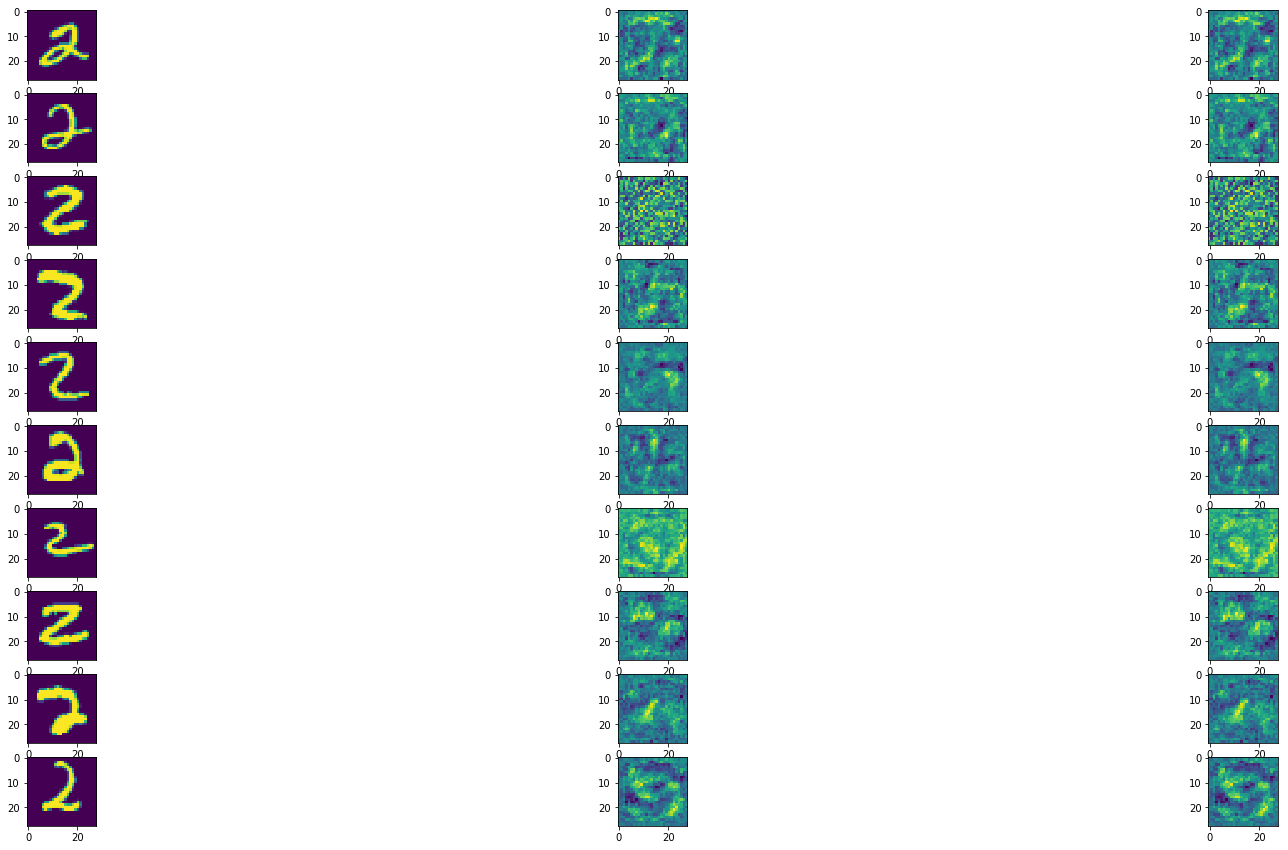

In [224]:
plot_figures(X_10_samples_2, X_10_noise)